x_train shape: (143, 8)
RMSE_train: 0.6569903300417022
R2_train: 0.9732793337782145
RMSE_test: 0.9540336892391903
R2_test: 0.9537404133090643


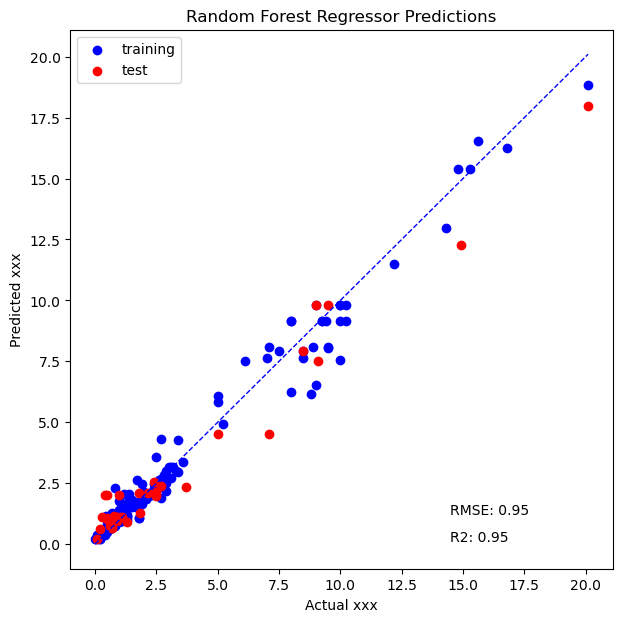

Generated virtual samples shape: (200, 8)
生成的虚拟样本（输入特征）：
 [[4.61725193e+00 4.07786907e-02 2.90662455e-01 ... 3.66586133e-02
  2.00056652e-01 2.09977746e-01]
 [4.65979742e+00 5.08904469e+00 7.40297822e-01 ... 0.00000000e+00
  0.00000000e+00 1.52041573e-02]
 [4.33548447e+00 0.00000000e+00 1.17056435e-03 ... 5.71640297e-02
  2.16850276e-02 4.34667332e-02]
 ...
 [1.84478519e+01 3.62376887e+00 9.53873511e-01 ... 2.25268527e-01
  3.70883809e-01 1.79417942e-01]
 [1.53998350e+01 4.98541661e+00 3.56017759e-01 ... 1.34734575e-01
  3.72626935e-01 1.94589123e-01]
 [8.29943239e+00 3.11007715e+00 5.95859435e-01 ... 2.45449153e-01
  3.23797528e-01 1.96267234e-01]]
生成的虚拟样本（输出标签）：
 [11.09363636  3.13097835  7.06271212  2.1424371   6.64155844  4.64443939
  1.15973318  1.41947532  5.23871645  6.09478139  4.30966017  5.9690404
  2.7555303   1.31048215  2.08563131  5.72740909  4.20859091  3.70495455
  3.95783333  2.19012869  5.46077273  2.3552297   5.34902597  5.70033333
  2.99852165 12.29864502  2.1616505

In [5]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from scipy import stats
import warnings
from sklearn.model_selection import train_test_split
import xgboost as xgb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor
from bayes_opt import BayesianOptimization

warnings.filterwarnings("ignore")

# 读取数据
data = pd.read_excel('EL.xlsx')

# 分割数据
X = data.iloc[:, 1:]
Y = data.iloc[:, 0]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=5)

# 数据归一化
scaler = MinMaxScaler()
x_train_normalized = scaler.fit_transform(x_train)

# 确保特征维度
print(f"x_train shape: {x_train.shape}")  # 输出训练集特征的形状

# 最佳参数
best_params = {
    'bootstrap': False,
    'max_depth': 10,
    'max_features': 0.5,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'n_estimators': 55
}

# 使用最佳参数训练最终模型
rf_model = RandomForestRegressor(**best_params, random_state=25)
rf_model.fit(x_train, y_train)
# 评价模型
rf_MSE = mean_squared_error(y_train, rf_model.predict(x_train))
rf_RMSE = np.sqrt(rf_MSE)
rf_R2 = r2_score(y_train, rf_model.predict(x_train))
print('RMSE_train: ' + str(rf_RMSE))
print('R2_train: ' + str(rf_R2))

rf_MSE_t = mean_squared_error(y_test, rf_model.predict(x_test))
rf_RMSE_t = np.sqrt(rf_MSE_t)
rf_R2_t = r2_score(y_test, rf_model.predict(x_test))
print('RMSE_test: ' + str(rf_RMSE_t))
print('R2_test: ' + str(rf_R2_t))

# 准备导出数据
train_results = pd.DataFrame({
    'Actual': y_train,
    'Predicted': rf_model.predict(x_train),
    'Type': 'Train'
})
test_results = pd.DataFrame({
    'Actual': y_test,
    'Predicted': rf_model.predict(x_test),
    'Type': 'Test'
})
results = pd.concat([train_results, test_results])

# 可视化结果
plt.figure(figsize=(7, 7))
plt.scatter(y_train, rf_model.predict(x_train), c="blue", label='training')
plt.scatter(y_test, rf_model.predict(x_test), c='red', label='test')
plt.plot([min(y_train), max(y_train)], [min(y_train), max(y_train)], 'b--', lw=1)
plt.xlabel('Actual xxx')
plt.ylabel('Predicted xxx')
plt.annotate(f'RMSE: {rf_RMSE_t:.2f}', xy=(0.7, 0.1), xycoords='axes fraction')
plt.annotate(f'R2: {rf_R2_t:.2f}', xy=(0.7, 0.05), xycoords='axes fraction')
plt.legend()
plt.title('Random Forest Regressor Predictions')
plt.show()
# 计算样本集中值
def compute_central_location(X):
    return np.mean(X, axis=0)

# 计算左右偏度
def compute_skewness(X, CL):
    N_L = np.sum(X < CL, axis=0)
    N_U = np.sum(X > CL, axis=0)
    skewness_L = N_L / (N_L + N_U + 1)
    skewness_U = N_U / (N_L + N_U + 1)
    return skewness_L, skewness_U

# 计算不对称接受域范围
def compute_asymmetric_range(X, CL, skewness_L, skewness_U):
    LB = CL - (1 / skewness_U) * (CL - np.min(X, axis=0))
    UB = CL + (1 / skewness_L) * (np.max(X, axis=0) - CL)
    return LB, UB

# PSO算法生成虚拟输入特征
def generate_virtual_samples(X, num_samples=100, num_particles=30, num_iterations=100):
    CL = compute_central_location(X)
    skewness_L, skewness_U = compute_skewness(X, CL)
    LB, UB = compute_asymmetric_range(X, CL, skewness_L, skewness_U)
    
    all_samples = []
    
    while len(all_samples) < num_samples:
        particles = np.random.uniform(LB, UB, (num_particles, X.shape[1]))
        velocities = np.zeros_like(particles)
        personal_best = particles.copy()
        global_best = particles[np.argmin(np.std(particles, axis=1))]

        for _ in range(num_iterations):
            r1, r2 = np.random.rand(), np.random.rand()
            velocities = 0.7 * velocities + 1.5 * r1 * (personal_best - particles) + 1.5 * r2 * (global_best - particles)
            particles = particles + velocities
            particles = np.clip(particles, LB, UB)
            particles = np.clip(particles, 0, None)  # 确保所有特征值为正
            
            current_best = particles[np.argmin(np.std(particles, axis=1))]
            if np.std(current_best) < np.std(global_best):
                global_best = current_best

        for particle in particles:
            if len(all_samples) < num_samples and not any(np.array_equal(particle, s) for s in all_samples):
                all_samples.append(particle)
    
    virtual_samples = np.array(all_samples)
    print(f"Generated virtual samples shape: {virtual_samples.shape}")  # 迭代信息
    return virtual_samples

# 生成虚拟输入特征
virtual_features_normalized = generate_virtual_samples(x_train_normalized, num_samples=200)

# 反归一化处理
virtual_features = scaler.inverse_transform(virtual_features_normalized)

# 确保虚拟输入特征的形状与训练集特征形状一致
assert virtual_features.shape[1] == x_train.shape[1],

# 预测虚拟样本的输出标签
virtual_labels = rf_model.predict(virtual_features)

# 应用Z-Score异常值检测
z_scores = np.abs(stats.zscore(virtual_features, axis=0))
outliers = (z_scores > 3).any(axis=1)
virtual_features_filtered = virtual_features[~outliers]
virtual_labels_filtered = virtual_labels[~outliers]

# 打印生成的虚拟样本
print("生成的虚拟样本（输入特征）：\n", virtual_features_filtered)
print("生成的虚拟样本（输出标签）：\n", virtual_labels_filtered)

# 将虚拟样本数据导出到Excel
virtual_data = pd.DataFrame(virtual_features_filtered, columns=X.columns)
virtual_data['Predicted_Output'] = virtual_labels_filtered
virtual_data.to_excel('EL_virtual_samples_filtered.xlsx', index=False)
print("虚拟样本数据已导出到 EL_virtual_samples_filtered.xlsx")


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import warnings
warnings.filterwarnings("ignore")

# 读取数据
data = pd.read_excel('EL_virtual_samples_filtered.xlsx')

# 数据归一化
scaler = MinMaxScaler()
data_normalized = scaler.fit_transform(data)

# 将归一化数据转换为DataFrame
data_normalized_df = pd.DataFrame(data_normalized, columns=data.columns)

# 将归一化数据导出为Excel文件
data_normalized_df.to_excel('EL_normalized.xlsx', index=False)

print("Normalized data has been saved to 'EL_normalized.xlsx'.")

In [ ]:
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

import xgboost as xgb
import shap
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

# 读取数据
data = pd.read_excel('EL_normalized.xlsx')

# 分割数据
X = data.iloc[:, 1:]
Y = data.iloc[:, 0]
x_train, x_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=5)

# 最佳参数
best_params = {
    'bootstrap': False,
    'max_depth': 10,
    'max_features': 0.5,
    'min_impurity_decrease': 0.0,
    'min_samples_leaf': 1,
    'min_samples_split': 5,
    'n_estimators': 55
}

# 使用最佳参数训练最终模型
rf_model = RandomForestRegressor(**best_params, random_state=25)
rf_model.fit(x_train, y_train)

# 计算SHAP值
explainer = shap.Explainer(rf_model)
shap_values = explainer(x_test)

# 初始化JavaScript库
shap.initjs()

# 特征重要性排序柱状图
shap.plots.bar(shap_values)

# 使用Matplotlib绘制SHAP力图
plt.figure()
shap_values_sample = shap_values[0]  # 选择第一个样本
feature_importance = np.abs(shap_values_sample.values).argsort()[::-1]  # 按照重要性排序特征
top_features = feature_importance[:8]  #输出8个特征

shap.force_plot(explainer.expected_value, shap_values_sample.values[top_features], x_test.iloc[0, top_features], matplotlib=True)
plt.show()

# SHAP值summary plot
shap.summary_plot(shap_values, x_test, plot_type="bar")

# SHAP summary plot with distribution
shap.summary_plot(shap_values, x_test)
